<a href="https://colab.research.google.com/github/solver-Mart1n/data-science/blob/main/activities/relational_database/sql/intermediate_sql/3_Lab_Sub-Queries_Nested_SELECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sub-queries and Nested Selects in SQLite using Jupyter Notebooks

**Estimated time needed:** 20 minutes

In this lab, you will learn how to create tables and load data in the [SQLite](https://docs.python.org/3/library/sqlite3.html) database service using Jupyter Notebooks. This notebook supports and runs on Google Colab.

<h2> Objectives </h2>

After completing this lab, you will be able to:
* Write SQL queries that demonstrate the necessity of using sub-queries
* Compose sub-queries in the where clause
* Build column expressions (for example, sub-query in place of a column)
* Write table expressions (for example, sub-query in place of a table)


## Database Definition
The database tables used in this lab activity are as follows.

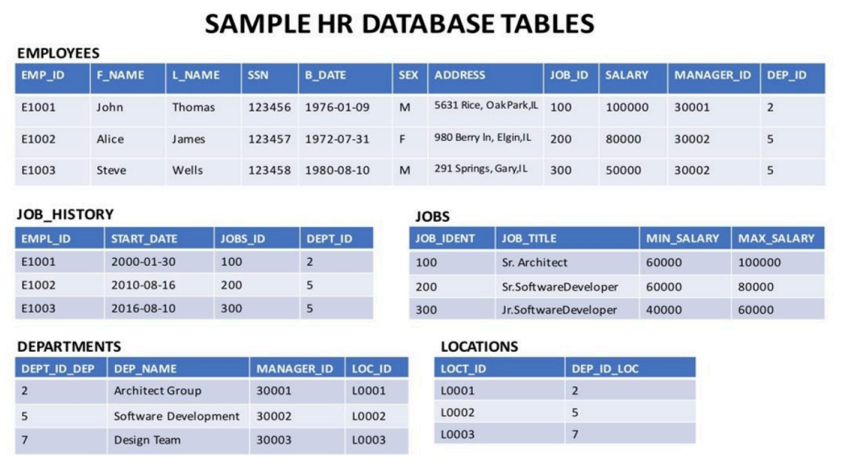

## Import Datasets from Kaggle to Google Colab

The database used in this lab is internal. You will be working on a sample Human Resources (HR) database. This HR database schema consists of five tables: EMPLOYEES, JOB_HISTORY, JOBS, DEPARTMENTS, and LOCATIONS.
Each table has a few rows of sample data. The following diagram shows the contents of the HR database:


### Authenticate Kaggle API Endpoint



In [3]:
! pip install kaggle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

### Download SQL Script and CSV Files


<h4>SQL script</h4>

In [6]:
! kaggle datasets download martinjohnhborja/hr-database -f Script_Create_Tables.sql

Dataset URL: https://www.kaggle.com/datasets/martinjohnhborja/hr-database
License(s): unknown
  0% 0.00/1.69k [00:00<?, ?B/s]
100% 1.69k/1.69k [00:00<00:00, 3.89MB/s]


<h4>CSV Source Files for database tables</h4>

Medical Departments

In [7]:
! kaggle datasets download martinjohnhborja/hr-database -f DEPARTMENTS.csv

Dataset URL: https://www.kaggle.com/datasets/martinjohnhborja/hr-database
License(s): unknown
  0% 0.00/85.0 [00:00<?, ?B/s]
100% 85.0/85.0 [00:00<00:00, 244kB/s]


Medical History

In [8]:
! kaggle datasets download martinjohnhborja/hr-database -f Employees.csv

Dataset URL: https://www.kaggle.com/datasets/martinjohnhborja/hr-database
License(s): unknown
  0% 0.00/836 [00:00<?, ?B/s]
100% 836/836 [00:00<00:00, 1.78MB/s]


Medical Locations

In [9]:
! kaggle datasets download martinjohnhborja/hr-database -f Jobs.csv

Dataset URL: https://www.kaggle.com/datasets/martinjohnhborja/hr-database
License(s): unknown
  0% 0.00/324 [00:00<?, ?B/s]
100% 324/324 [00:00<00:00, 626kB/s]


Medical Procedures

In [10]:
! kaggle datasets download martinjohnhborja/hr-database -f JobsHistory.csv

Dataset URL: https://www.kaggle.com/datasets/martinjohnhborja/hr-database
License(s): unknown
  0% 0.00/240 [00:00<?, ?B/s]
100% 240/240 [00:00<00:00, 533kB/s]


Patients

In [11]:
! kaggle datasets download martinjohnhborja/hr-database -f Locations.csv

Dataset URL: https://www.kaggle.com/datasets/martinjohnhborja/hr-database
License(s): unknown
  0% 0.00/24.0 [00:00<?, ?B/s]
100% 24.0/24.0 [00:00<00:00, 53.2kB/s]


## Task 1: Create the database

In [12]:
file_path = '/content/Script_Create_Tables.sql'

In [13]:
import pandas as pd
import sqlite3
from sqlite3 import OperationalError

conn = sqlite3.connect('hr.db')
c = conn.cursor()

## Task 2: Create tables using SQL script

### Build the database structure

In [14]:
def executeScriptsFromFile(filename):
    # Open and read the file as a single buffer
    fd = open(filename, 'r')
    sqlFile = fd.read()
    fd.close()

    # all SQL commands (split on ';')
    sqlCommands = sqlFile.split(';')

    # Execute every command from the input file
    for command in sqlCommands:
        # This will skip and report errors
        # For example, if the tables do not yet exist, this will skip over
        # the DROP TABLE commands
        try:
            c.execute(command)
            print(command)
        except (OperationalError, msg):
            print("Command skipped: ", msg)

In [15]:
executeScriptsFromFile(file_path)

CREATE TABLE EMPLOYEES (
                            EMP_ID CHAR(9) NOT NULL, 
                            F_NAME VARCHAR(15) NOT NULL,
                            L_NAME VARCHAR(15) NOT NULL,
                            SSN CHAR(9),
                            B_DATE DATE,
                            SEX CHAR,
                            ADDRESS VARCHAR(30),
                            JOB_ID CHAR(9),
                            SALARY DECIMAL(10,2),
                            MANAGER_ID CHAR(9),
                            DEP_ID CHAR(9) NOT NULL,
                            PRIMARY KEY (EMP_ID))

                            
  CREATE TABLE JOB_HISTORY (
                            EMPL_ID CHAR(9) NOT NULL, 
                            START_DATE DATE,
                            JOBS_ID CHAR(9) NOT NULL,
                            DEPT_ID CHAR(9),
                            PRIMARY KEY (EMPL_ID,JOBS_ID))

 
 CREATE TABLE JOBS (
                            JOB_IDENT CHAR(9) NOT NU

### Check contents of tables using SQL Alchemy

Setup an SQL Extension using the cvd.db SQLite database. We will use this to show the tables are initially empty. Later, we will check whether we loaded the CSVs successfully.

In [16]:
!pip install sqlalchemy

In [17]:
%reload_ext sql

In [18]:
%sql sqlite:///hr.db

Check tables using SQL SELECT queries. Empty tables should only return the column headers.

In [19]:
%%sql
SELECT *
FROM DEPARTMENTS;

 * sqlite:///hr.db
Done.


DEPT_ID_DEP,DEP_NAME,MANAGER_ID,LOC_ID


In [20]:
%%sql
SELECT *
FROM JOB_HISTORY;

 * sqlite:///hr.db
Done.


EMPL_ID,START_DATE,JOBS_ID,DEPT_ID


In [21]:
%%sql
SELECT *
FROM LOCATIONS;

 * sqlite:///hr.db
Done.


LOCT_ID,DEP_ID_LOC


In [22]:
%%sql
SELECT *
FROM JOBS;

 * sqlite:///hr.db
Done.


JOB_IDENT,JOB_TITLE,MIN_SALARY,MAX_SALARY


In [23]:
%%sql
SELECT *
FROM EMPLOYEES;

 * sqlite:///hr.db
Done.


EMP_ID,F_NAME,L_NAME,SSN,B_DATE,SEX,ADDRESS,JOB_ID,SALARY,MANAGER_ID,DEP_ID


## Task 3: Load data into tables

### Load data using python scripts

In [24]:
from sqlite3.dbapi2 import IntegrityError

In [25]:
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
raw_tables = c.fetchall()
tables = []
for table in raw_tables:
    tables.append(table[0])

In [26]:
tables

['EMPLOYEES', 'JOB_HISTORY', 'JOBS', 'DEPARTMENTS', 'LOCATIONS']

The list of tables is used to get a list of table column variables or features.

The get_columns(), set_csv_file_name(), and load_csv_to_sql_table() methods take in table names. Due to the naming convention used in the CSV files, the pipeline only requires the table names, a pandas data frame, and the sqlite3 connector object to load the database tables with data.

In [27]:
def get_columns(tablename):
    cursor = c.execute("select * from " + tablename)
    names = list(map(lambda x:x[0], cursor.description))
    return names

In [28]:
dict_csv_file = {'EMPLOYEES':'Employees', 'JOB_HISTORY':'JobsHistory', 'JOBS':'Jobs', 'DEPARTMENTS':'Departments', 'LOCATIONS':'Locations'}

In [29]:
def set_csv_file_name(table):
    csv_file = "/content/" + dict_csv_file[table] + ".csv"
    return csv_file

In [30]:
def load_csv_to_sql_table(csv,table):
    df_table = pd.read_csv(csv, header=None)
    df_table.columns = get_columns(table)
    try:
        df_table.to_sql(table, conn, if_exists='append', index = False)
    except IntegrityError as e:
        print(repr(e))
    return(df_table)

The load_csv_to_sql_table() method is invoked iteratively for each table in the list of tables.

In [31]:
for table in tables:
    df = load_csv_to_sql_table(set_csv_file_name(table),table)
    print(df)

  EMP_ID   F_NAME   L_NAME     SSN      B_DATE SEX  \
0  E1001     John   Thomas  123456  1976-09-01   M   
1  E1002    Alice    James  123457  1972-07-31   F   
2  E1003    Steve    Wells  123458  1980-10-08   M   
3  E1004  Santosh    Kumar  123459  1985-07-20   M   
4  E1005    Ahmed  Hussain  123410  1981-04-01   M   
5  E1006    Nancy    Allen  123411  1978-06-02   F   
6  E1007     Mary   Thomas  123412  1975-05-05   F   
7  E1008  Bharath    Gupta  123413  1985-06-05   M   
8  E1009   Andrea    Jones  123414  1990-09-07   F   
9  E1010      Ann    Jacob  123415  1982-03-30   F   

                        ADDRESS  JOB_ID  SALARY  MANAGER_ID  DEP_ID  
0         5631 Rice, OakPark,IL     100  100000       30001       2  
1        980 Berry ln, Elgin,IL     200   80000       30002       5  
2          291 Springs, Gary,IL     300   50000       30002       5  
3      511 Aurora Av, Aurora,IL     400   60000       30002       5  
4       216 Oak Tree, Geneva,IL     500   70000       3

### Check tables using SQL SELECT queries.

As an indicator of success, each table in the database shall return contents from the CSV files after the loading process.

In [32]:
%%sql
SELECT *
FROM DEPARTMENTS;

 * sqlite:///hr.db
Done.


DEPT_ID_DEP,DEP_NAME,MANAGER_ID,LOC_ID
2,Architect Group,30001,L0001
5,Software Group,30002,L0002
7,Design Team,30003,L0003


In [33]:
%%sql
SELECT *
FROM JOB_HISTORY;

 * sqlite:///hr.db
Done.


EMPL_ID,START_DATE,JOBS_ID,DEPT_ID
E1001,2000-08-01,100,2
E1002,2001-08-01,200,5
E1003,2001-08-16,300,5
E1004,2000-08-16,400,5
E1005,2000-05-30,500,2
E1006,2001-08-16,600,2
E1007,2002-05-30,650,7
E1008,2010-05-06,660,7
E1009,2016-08-16,234,7
E1010,2016-08-16,220,5


In [34]:
%%sql
SELECT *
FROM LOCATIONS;

 * sqlite:///hr.db
Done.


LOCT_ID,DEP_ID_LOC
L0001,2
L0002,5
L0003,7


In [35]:
%%sql
SELECT *
FROM JOBS;

 * sqlite:///hr.db
Done.


JOB_IDENT,JOB_TITLE,MIN_SALARY,MAX_SALARY
100,Sr. Architect,60000,100000
200,Sr. Software Developer,60000,80000
300,Jr.Software Developer,40000,60000
400,Jr.Software Developer,40000,60000
500,Jr. Architect,50000,70000
600,Lead Architect,70000,100000
650,Jr. Designer,60000,70000
660,Jr. Designer,60000,70000
234,Sr. Designer,70000,90000
220,Sr. Designer,70000,90000


In [36]:
%%sql
SELECT *
FROM EMPLOYEES;

 * sqlite:///hr.db
Done.


EMP_ID,F_NAME,L_NAME,SSN,B_DATE,SEX,ADDRESS,JOB_ID,SALARY,MANAGER_ID,DEP_ID
E1001,John,Thomas,123456,1976-09-01,M,"5631 Rice, OakPark,IL",100,100000,30001,2
E1002,Alice,James,123457,1972-07-31,F,"980 Berry ln, Elgin,IL",200,80000,30002,5
E1003,Steve,Wells,123458,1980-10-08,M,"291 Springs, Gary,IL",300,50000,30002,5
E1004,Santosh,Kumar,123459,1985-07-20,M,"511 Aurora Av, Aurora,IL",400,60000,30002,5
E1005,Ahmed,Hussain,123410,1981-04-01,M,"216 Oak Tree, Geneva,IL",500,70000,30001,2
E1006,Nancy,Allen,123411,1978-06-02,F,"111 Green Pl, Elgin,IL",600,90000,30001,2
E1007,Mary,Thomas,123412,1975-05-05,F,"100 Rose Pl, Gary,IL",650,65000,30003,7
E1008,Bharath,Gupta,123413,1985-06-05,M,"145 Berry Ln, Naperville,IL",660,65000,30003,7
E1009,Andrea,Jones,123414,1990-09-07,F,"120 Fall Creek, Gary,IL",234,70000,30003,7
E1010,Ann,Jacob,123415,1982-03-30,F,"111 Britany Springs,Elgin,IL",220,70000,30002,5


## Task 4: Sub-queries and Nested Selects

Say you are asked to retrieve all employee records whose salary is lower than the average salary. You might use the following query to do this.

In [39]:
%%sql
SELECT *
FROM EMPLOYEES
WHERE salary < AVG(salary);

 * sqlite:///hr.db
(sqlite3.OperationalError) misuse of aggregate function AVG()
[SQL: SELECT *
FROM EMPLOYEES 
WHERE salary < AVG(salary);]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


However, this query will generate an error stating, "Illegal use of group function." Here, the group function is AVG and cannot be used directly in the condition since it has not been retrieved from the data. Therefore,
the condition will use a sub-query to retrieve the average salary information to compare the existing salary. The modified query would become:

In [40]:
%%sql
SELECT *
FROM EMPLOYEES
WHERE SALARY < (SELECT AVG(SALARY) FROM EMPLOYEES);

 * sqlite:///hr.db
Done.


EMP_ID,F_NAME,L_NAME,SSN,B_DATE,SEX,ADDRESS,JOB_ID,SALARY,MANAGER_ID,DEP_ID
E1003,Steve,Wells,123458,1980-10-08,M,"291 Springs, Gary,IL",300,50000,30002,5
E1004,Santosh,Kumar,123459,1985-07-20,M,"511 Aurora Av, Aurora,IL",400,60000,30002,5
E1005,Ahmed,Hussain,123410,1981-04-01,M,"216 Oak Tree, Geneva,IL",500,70000,30001,2
E1007,Mary,Thomas,123412,1975-05-05,F,"100 Rose Pl, Gary,IL",650,65000,30003,7
E1008,Bharath,Gupta,123413,1985-06-05,M,"145 Berry Ln, Naperville,IL",660,65000,30003,7
E1009,Andrea,Jones,123414,1990-09-07,F,"120 Fall Creek, Gary,IL",234,70000,30003,7
E1010,Ann,Jacob,123415,1982-03-30,F,"111 Britany Springs,Elgin,IL",220,70000,30002,5


Now, consider executing a query that retrieves all employee records with EMP_ID, SALARY, and maximum salary as MAX_SALARY in every row. For this, the maximum salary must be queried and used as one of
the columns. This can be done using the query below.

In [45]:
%%sql
SELECT EMP_ID, SALARY, (SELECT MAX(SALARY) FROM EMPLOYEES) AS MAX_SALARY
FROM EMPLOYEES;

 * sqlite:///hr.db
Done.


EMP_ID,SALARY,MAX_SALARY
E1001,100000,100000
E1002,80000,100000
E1003,50000,100000
E1004,60000,100000
E1005,70000,100000
E1006,90000,100000
E1007,65000,100000
E1008,65000,100000
E1009,70000,100000
E1010,70000,100000


Now, consider that you wish to extract the first and last names of the oldest employee. Since the oldest employee will be the one with the smallest date of birth, the query can be written as:

In [46]:
%%sql
SELECT F_NAME, L_NAME
FROM EMPLOYEES
WHERE B_DATE = (SELECT MIN(B_DATE) FROM EMPLOYEES);

 * sqlite:///hr.db
Done.


F_NAME,L_NAME
Alice,James


You may also use sub-queries to create derived tables, which can then be used to query specific information. Say you want to know the average salary of the top 5 earners in the company. You will first have to extract
a table of the top five salaries as a table. From that table, you can query the average value of the salary. The query can be written as follows.

In [48]:
%%sql
SELECT AVG(SALARY)
FROM (SELECT SALARY
FROM EMPLOYEES
ORDER BY SALARY DESC
LIMIT 5) AS SALARY_TABLE;

 * sqlite:///hr.db
Done.


AVG(SALARY)
82000.0


## Practice Problems

<h3> 1. Write a query to find the average salary of the five least-earning employees.</h3>

<details><summary>Solution</summary>


```
%%sql
SELECT AVG(SALARY)
FROM (SELECT SALARY
FROM EMPLOYEES
ORDER BY SALARY
LIMIT 5) AS SALARY_TABLE;
```

</details>

In [55]:
%%sql
SELECT AVG(SALARY)
FROM (SELECT SALARY
FROM EMPLOYEES
ORDER BY SALARY
LIMIT 5) AS SALARY_TABLE;

 * sqlite:///hr.db
Done.


AVG(SALARY)
62000.0


<h3> 2. Write a query to find the records of employees older than the average age of all employees.</h3>

<details><summary>Solution</summary>


```
-- In SQLite...
%%sql
SELECT *
FROM EMPLOYEES
WHERE cast(strftime('%Y.%m%d', 'now') - strftime('%Y.%m%d', B_DATE) as int) >
(SELECT AVG(cast(strftime('%Y.%m%d', 'now') - strftime('%Y.%m%d', B_DATE) as int))
FROM EMPLOYEES);
-- In MySQL...
%%sql
SELECT *
FROM EMPLOYEES
WHERE YEAR(FROM_DAYS(DATEDIFF(CURRENT_DATE,B_DATE))) >
(SELECT AVG(YEAR(FROM_DAYS(DATEDIFF(CURRENT_DATE,B_DATE))))
FROM EMPLOYEES);

```

</details>

In [57]:
%%sql
SELECT *
FROM EMPLOYEES
WHERE cast(strftime('%Y.%m%d', 'now') - strftime('%Y.%m%d', B_DATE) as int) >
(SELECT AVG(cast(strftime('%Y.%m%d', 'now') - strftime('%Y.%m%d', B_DATE) as int))
FROM EMPLOYEES);

 * sqlite:///hr.db
Done.


EMP_ID,F_NAME,L_NAME,SSN,B_DATE,SEX,ADDRESS,JOB_ID,SALARY,MANAGER_ID,DEP_ID
E1001,John,Thomas,123456,1976-09-01,M,"5631 Rice, OakPark,IL",100,100000,30001,2
E1002,Alice,James,123457,1972-07-31,F,"980 Berry ln, Elgin,IL",200,80000,30002,5
E1003,Steve,Wells,123458,1980-10-08,M,"291 Springs, Gary,IL",300,50000,30002,5
E1005,Ahmed,Hussain,123410,1981-04-01,M,"216 Oak Tree, Geneva,IL",500,70000,30001,2
E1006,Nancy,Allen,123411,1978-06-02,F,"111 Green Pl, Elgin,IL",600,90000,30001,2
E1007,Mary,Thomas,123412,1975-05-05,F,"100 Rose Pl, Gary,IL",650,65000,30003,7


<h3> 3. From the Job_History table, display the list of Employee IDs, years of service, and average years of service for all entries.</h3>

<details><summary>Solution</summary>


```
-- In SQLite...
%%sql
SELECT EMPL_ID,
    cast(strftime('%Y.%m%d', 'now') - strftime('%Y.%m%d', START_DATE) as int) AS YOS,
    (SELECT AVG(cast(strftime('%Y.%m%d', 'now') - strftime('%Y.%m%d', START_DATE) as int))
    FROM JOB_HISTORY) AS AVG_YOS
FROM JOB_HISTORY;
-- In MySQL...
%%sql
SELECT EMPL_ID, YEAR(FROM_DAYS(DATEDIFF(CURRENT_DATE, START_DATE))),
(SELECT AVG(YEAR(FROM_DAYS(DATEDIFF(CURRENT_DATE, START_DATE))))
FROM JOB_HISTORY)
FROM JOB_HISTORY;
```

</details>

In [64]:
%%sql
SELECT EMPL_ID,
    cast(strftime('%Y.%m%d', 'now') - strftime('%Y.%m%d', START_DATE) as int) AS YOS,
    (SELECT AVG(cast(strftime('%Y.%m%d', 'now') - strftime('%Y.%m%d', START_DATE) as int))
    FROM JOB_HISTORY) AS AVG_YOS
FROM JOB_HISTORY;

 * sqlite:///hr.db
Done.


EMPL_ID,YOS,AVG_YOS
E1001,23,18.4
E1002,22,18.4
E1003,22,18.4
E1004,23,18.4
E1005,23,18.4
E1006,22,18.4
E1007,21,18.4
E1008,14,18.4
E1009,7,18.4
E1010,7,18.4


## Conclusion

Congratulations! You have completed this lab and are ready for the next topic.

You should now be able to:

* Write SQL queries that demonstrate the necessity of using sub-queries
* Compose sub-queries in the WHERE clause
* Build Column Expressions (for example, sub-query in place of a column)
* Write Table Expressions (for example, sub-query in place of a table)


## Credit to the Source Content
This python notebook uses the content of **Hands-on Lab: Sub-queries and Nested Selects** by IBM Skills Network from the [Databases and SQL for Data Science with Python](https://www.coursera.org/learn/sql-data-science) course. The source content uses the MySQL phpMyAdmin GUI tool for all SQL server interactions instead of SQLite and Jupyter Notebooks running on Google Colab.

### Change Log
All versions prior to 1.4, are attributable to IBM Skills Network's version of the **Hands-on Lab: Sub-queries and Nested Selects** written for MySQL phpMyAdmin server GUI tool.


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description        |
| ----------------- | ------- | ------------- | ------------------------- |
|2024-05-09|1.4|Martin Borja|Ported to Jupyter/Python Notebooks using toy HR database; Restructured, added comments and translated solutions to SQLite from MySQL |
|2024-02-16| 1.3| D.M.Naidu| Minor updates have been made to the queries|
|2023-10-11| 1.2| Beth Larsen| QA pass, minor text edits|
|2023-10-11| 1.1| Misty Taylor| ID Check|
|2023-10-10| 1.0| Abhishek Gagneja| New Version of the lab created|
|2023-05-04| 0.3| Rahul Jaideep| Updated Markdown file|
|2022-07-27| 0.2| Lakshmi Holla| Updated HTML tag|
|2021-11-01| 0.1| Lakshmi Holla, Malika Singla| Initial Version|

<br>

<hr>

### <h4 align="center"> **Hands-on Lab: Sub-queries and Nested Selects** © IBM Corporation 2023. All rights reserved. </h4>
### <h4 align="center"> **Sub-queries and Nested Selects in SQL using Jupyter Notebooks** © Martin John Hilario Borja 2024. All rights reserved. </h4>

<p>